In [ ]:
!pip install transformers

In [ ]:
!pip install tensorflow

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from matplotlib import colors
from wordcloud import WordCloud
from scipy.sparse import hstack, csr_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from transformers import AutoTokenizer
import tensorflow as tf
from transformers import  TFBertForSequenceClassification, AutoModelForSequenceClassification

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_data = pd.read_csv('data/shuffled_train_data.csv', index_col = None)
train_labels = pd.read_csv('data/shuffled_train_labels.csv', index_col = None)

test_data = pd.read_csv('data/test_data.csv',index_col = None)
test_labels = pd.read_csv('data/test_labels.csv',index_col = None)

validation_data = pd.read_csv('data/validation_data.csv',index_col = None)
validation_labels = pd.read_csv('data/validation_labels.csv',index_col = None)

train_data.shape

(2100, 1)

In [ ]:
train_labels.rename(columns={'0': "label"}, inplace=True)
print(train_labels.columns)

Index(['label'], dtype='object')


In [ ]:
def assign_values(row):
    if row['no_depression']:
        return 0
    elif row['true_depression']:
        return 2
    else:
        return 1

In [ ]:
y = list(train_labels['label'])
y = pd.get_dummies(y)
# print(y)
y['value'] = y.apply(assign_values, axis=1)
# print(y)

y_test = list(test_labels['label'])
y_test = pd.get_dummies(y_test)
y_test['value'] = y_test.apply(assign_values, axis=1)

y_validation = list(validation_labels['label'])
y_validation = pd.get_dummies(y_validation)
y_validation['value'] = y_validation.apply(assign_values, axis=1)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('dumitrescustefan/bert-base-romanian-cased-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/397k [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(list(train_data['text']), padding = True, truncation=True, max_length=128)

validation_encodings = tokenizer(list(validation_data['text']),truncation=True, padding = True, max_length=128)

test_encodings = tokenizer(list(test_data['text']),truncation=True, padding = True, max_length=128)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y['value']
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test['value']
))

validation_dataset = tf.data.Dataset.from_tensor_slices((
    dict(validation_encodings),
    y_validation['value']
))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('dumitrescustefan/bert-base-romanian-cased-v1',
                                                              num_labels = 3, from_pt=True)
#incercat lr = 5e-5
#de incercat lr = 2e-5
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5)

#compile the model
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['accuracy'])

#train the model
model.fit(train_dataset.shuffle(len(train_data)).batch(4),
              epochs = 4,
              batch_size = 4,
              validation_data = validation_dataset.shuffle(len(validation_data)).batch(4))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
525/525 [==============================] - 127s 134ms/step - loss: 0.6821 - accuracy: 0.7100 - val_loss: 0.6795 - val_accuracy: 0.6772
Epoch 2/4
525/525 [==============================] - 49s 93ms/step - loss: 0.5467 - accuracy: 0.7576 - val_loss: 0.6988 - val_accuracy: 0.6667
Epoch 3/4
525/525 [==============================] - 47s 89ms/step - loss: 0.3291 - accuracy: 0.8738 - val_loss: 0.8037 - val_accuracy: 0.6817
Epoch 4/4
525/525 [==============================] - 46s 88ms/step - loss: 0.1545 - accuracy: 0.9443 - val_loss: 1.0547 - val_accuracy: 0.6667


In [ ]:
model.evaluate(test_dataset.shuffle(len(test_data)).batch(4),
               return_dict=True,
               batch_size=4)

332/332 [==============================] - 9s 26ms/step - loss: 0.9389 - accuracy: 0.7034


{'loss': 0.9389007091522217, 'accuracy': 0.703396201133728}

In [ ]:
predictions = model.predict(test_dataset.batch(4))

332/332 [==============================] - 17s 26ms/step


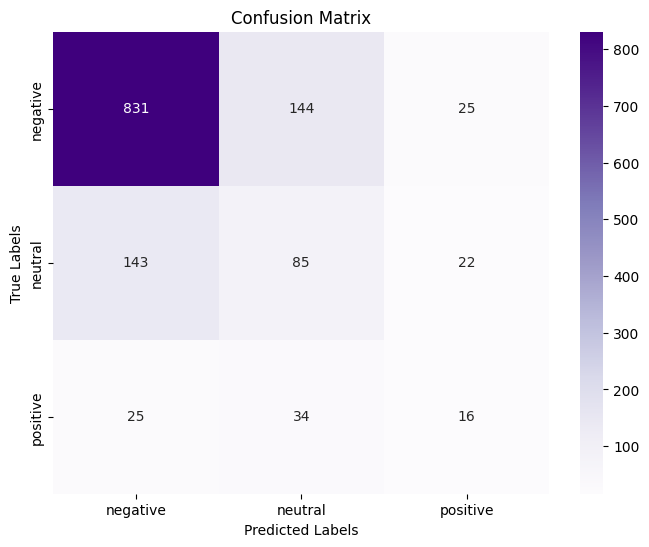

In [ ]:
predicted_labels = np.argmax(predictions.logits, axis=1)

import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test['value'], predicted_labels)
#batch 2, lr 5e-5 maxim value 256
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels = ['negative', 'neutral', 'positive'], yticklabels = ['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test['value'], predicted_labels))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.32      0.34      0.33       250
           2       0.25      0.21      0.23        75

    accuracy                           0.70      1325
   macro avg       0.47      0.46      0.46      1325
weighted avg       0.70      0.70      0.70      1325



In [ ]:
predictions